# Evaluation metrics for Classification

In the previous session we trained a model for predicting churn. How do we know if it's good?

## 4.1 Evaluation metrics: session overview

- Dataset: https://www.kaggle.com/blastchar/telco-customer-churn
- https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/chapter-03-churn-prediction/WA_Fn-UseC_-Telco-Customer-Churn.csv

Metric - function that compares the predictions with the actual values and outputs a single number that tells how good the predictions are


In [5]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from matplotlib import style

style.use('seaborn')

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression

In [7]:
df = pd.read_csv('data-week-3.csv')

df.columns = df.columns.str.lower().str.replace(' ', '_')

categorical_columns = list(df.dtypes[df.dtypes == 'object'].index)

for c in categorical_columns:
    df[c] = df[c].str.lower().str.replace(' ', '_')

df.totalcharges = pd.to_numeric(df.totalcharges, errors='coerce')
df.totalcharges = df.totalcharges.fillna(0)

df.churn = (df.churn == 'yes').astype(int)

In [8]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = df_train.churn.values
y_val = df_val.churn.values
y_test = df_test.churn.values

del df_train['churn']
del df_val['churn']
del df_test['churn']

In [9]:
numerical = ['tenure', 'monthlycharges', 'totalcharges']

categorical = [
    'gender',
    'seniorcitizen',
    'partner',
    'dependents',
    'phoneservice',
    'multiplelines',
    'internetservice',
    'onlinesecurity',
    'onlinebackup',
    'deviceprotection',
    'techsupport',
    'streamingtv',
    'streamingmovies',
    'contract',
    'paperlessbilling',
    'paymentmethod',
]

In [10]:
dv = DictVectorizer(sparse=False)

train_dict = df_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dict)

model = LogisticRegression()
model.fit(X_train, y_train)

LogisticRegression()

In [11]:
val_dict = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dict)

y_pred = model.predict_proba(X_val)[:, 1]
churn_decision = (y_pred >= 0.5)
(y_val == churn_decision).mean()

0.8034066713981547

## 4.2 Accuracy and dummy model

- Evaluate the model on different thresholds
- Check the accuracy of dummy baselines

$$ Accuracy = \frac{Correct Predictions}{N Samples}

In [12]:
len(y_val)

1409

In [13]:
correct = (y_val == churn_decision).sum()
correct

1132

In [14]:
print(f"Accuracy {correct/len(y_val)}")

Accuracy 0.8034066713981547


What if we change the decision threshold?

In [15]:
from sklearn.metrics import accuracy_score

In [16]:
thresholds = np.linspace(0,1,21)
scores = []
for thr in thresholds:
    churn_decision = (y_pred >= thr)
    score = accuracy_score(y_val,churn_decision)
    scores.append(score)

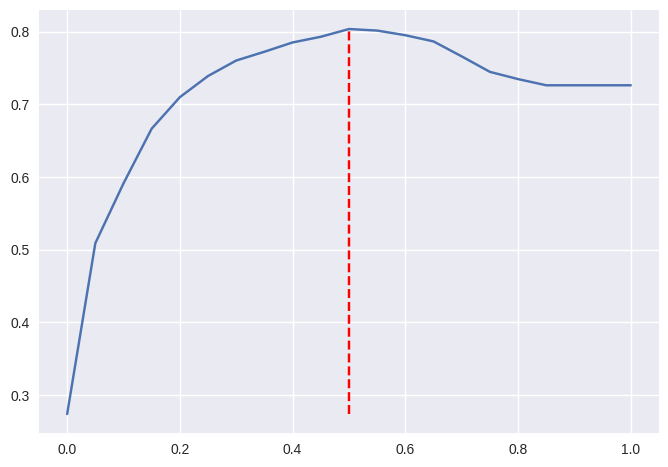

In [17]:
max_score_idx = scores.index(max(scores))
plt.plot(thresholds,scores)
plt.vlines(x=thresholds[max_score_idx],ymin=min(scores),ymax=max(scores),color='r',ls='--')

The accuracy of the predictions using a threshold of 1, we see that the accuracy is quite high (~0.73). But why is that?

In [18]:
from collections import Counter

In [19]:
Counter(y_pred >= 1.0)

Counter({False: 1409})

If we look at the distribution of y_val, we see that there are a lot more non-churning users. We see that ~27% of the users are churning. If we predict everything as non-churning, we will have a high accuracy. The model is only incorrect for the cases where the users are churning (~27%). This problem is refered to class imbalance. Thus, accuracy is not the best metric for problems where we find that the classes are imbalanced.

In [20]:
Counter(y_val)

Counter({0: 1023, 1: 386})

In [21]:
1 - y_val.mean()

0.7260468417317246

## 4.3 Confusion table

- Different types of errors and correct decisions
- Arrange them in a table

In [22]:
actual_positive = (y_val == 1)
actual_negative = (y_val == 0)

In [23]:
threshold = 0.5
pred_positive = (y_pred >= threshold)
pred_negative = (y_pred < threshold)

In [24]:
(actual_positive & pred_positive)[:5]

array([False, False, False,  True, False])

In [25]:
true_positive = (actual_positive & pred_positive).sum()
true_negative = (actual_negative & pred_negative).sum()

print(f"tp ={true_positive}, tn ={true_negative}")

tp =210, tn =922


In [26]:
false_positive = (pred_positive & actual_negative).sum()
false_negative = (pred_negative & actual_positive).sum()

print(f"fp = {false_positive}, fn = {false_negative}")

fp = 101, fn = 176


| Actual/Predictions | Negative | Positive |
|-------------|----------|----------|
| Negative    | TN = 922      | FP  = 101      |
| Positive    | FN = 176      | TP  = 210     |


In [27]:
confusion_matrix = np.array([
    [true_negative,false_positive],
    [false_negative,true_positive]
])

In [28]:
confusion_matrix

array([[922, 101],
       [176, 210]])

In [29]:
norm_confusion_matrix = np.round(confusion_matrix / confusion_matrix.sum(),2)
norm_confusion_matrix

array([[0.65, 0.07],
       [0.12, 0.15]])

$$Accuracy = tn + tp$$

## 4.4 Precision and Recall 

Metris to evaluate binary classification models.

Precision: Fraction of positive predictions that are correct. $$precision = \frac{Tp}{Tp+Fp}$$

Recall: Fraction of correctly identified positive examples. We are interested in the actual positive points. $$recall=\frac{Tp}{NumPositiveobs}=\frac{Tp}{Tp+Fn}$$

Approx 33% of positive predictions are actually negative. (1-precision)

In [30]:
precision = true_positive/(true_positive+false_positive)
precision

0.6752411575562701

The model failed identifying 46% of people churning (actual positive)

In [31]:
recall = true_positive/(true_positive+false_negative)
recall

0.5440414507772021

## 4.5 ROC Curves

ROC = Receiver operating characteristic

$$FPR = \frac{Fp}{Tn + Fp}$$
$$TPR = \frac{Tp}{Fn + Tp}$$

We want to minimize the False positive rate (FPR) and maximize the True Positive rate (TPR).

In [34]:
tpr  = true_positive / (true_positive+ false_negative)
tpr

0.5440414507772021

TPR is the same as recall 

In [36]:
recall

0.5440414507772021

In [35]:
fpr = false_positive / (true_negative + false_positive)
fpr

0.09872922776148582

In [37]:
thresholds = np.linspace(0,1,101)

actual_positive = (y_val == 1)
actual_negative = (y_val == 0)

scores = []
for threshold in thresholds:

    pred_positive = (y_pred >= threshold)
    pred_negative = (y_pred < threshold)

    tp = (actual_positive & pred_positive).sum()
    tn = (actual_negative & pred_negative).sum()

    fp = (pred_positive & actual_negative).sum()
    fn = (pred_negative & actual_positive).sum()

    scores.append((threshold,tp,fp,fn,tn))

scores

[(0.0, 386, 1023, 0, 0),
 (0.01, 385, 913, 1, 110),
 (0.02, 384, 830, 2, 193),
 (0.03, 383, 766, 3, 257),
 (0.04, 381, 715, 5, 308),
 (0.05, 379, 685, 7, 338),
 (0.06, 377, 661, 9, 362),
 (0.07, 372, 641, 14, 382),
 (0.08, 371, 613, 15, 410),
 (0.09, 369, 580, 17, 443),
 (0.1, 366, 556, 20, 467),
 (0.11, 365, 528, 21, 495),
 (0.12, 365, 509, 21, 514),
 (0.13, 360, 477, 26, 546),
 (0.14, 355, 453, 31, 570),
 (0.15, 351, 435, 35, 588),
 (0.16, 347, 419, 39, 604),
 (0.17, 346, 401, 40, 622),
 (0.18, 344, 384, 42, 639),
 (0.19, 338, 369, 48, 654),
 (0.2, 333, 356, 53, 667),
 (0.21, 330, 341, 56, 682),
 (0.22, 323, 322, 63, 701),
 (0.23, 320, 313, 66, 710),
 (0.24, 316, 303, 70, 720),
 (0.25, 309, 291, 77, 732),
 (0.26, 304, 281, 82, 742),
 (0.27, 303, 270, 83, 753),
 (0.28, 295, 256, 91, 767),
 (0.29, 291, 244, 95, 779),
 (0.3, 284, 236, 102, 787),
 (0.31, 280, 230, 106, 793),
 (0.32, 278, 226, 108, 797),
 (0.33, 276, 221, 110, 802),
 (0.34, 274, 212, 112, 811),
 (0.35000000000000003, 272,

In [39]:
df_scores = pd.DataFrame(scores,columns=['threshold','tp','fp','fn','tn'])

In [40]:
df_scores[::10]

,threshold,tp,fp,fn,tn
0,0.0,386,1023,0,0
10,0.1,366,556,20,467
20,0.2,333,356,53,667
30,0.3,284,236,102,787
40,0.4,249,166,137,857
50,0.5,210,101,176,922
60,0.6,150,53,236,970
70,0.7,76,20,310,1003
80,0.8,13,1,373,1022
90,0.9,0,0,386,1023


In [43]:
df_scores['tpr'] = df_scores.tp / (df_scores.tp + df_scores.fn)
df_scores['fpr'] = df_scores.fp / (df_scores.fp + df_scores.tn)

<AxesSubplot:xlabel='threshold'>

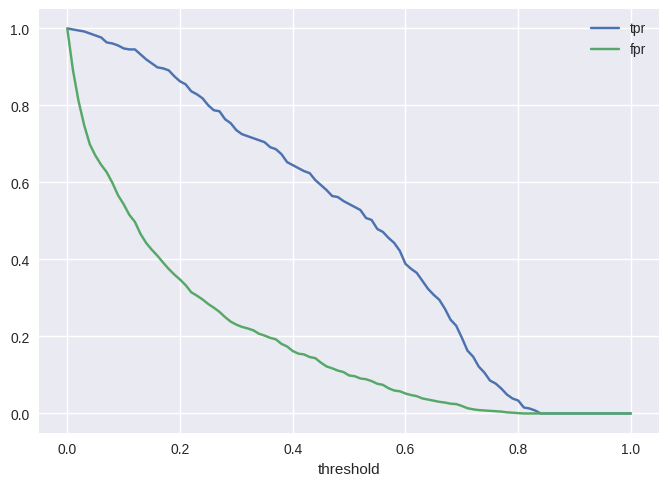

In [46]:
df_scores.plot(x='threshold',y=['tpr','fpr'])

### Random Model

In [47]:
np.random.seed(1)

y_rand = np.random.uniform(0,1,size=len(y_val))
y_rand.round(3)

array([0.417, 0.72 , 0.   , ..., 0.774, 0.334, 0.089])

In [48]:
((y_rand >=0.5) == y_val).mean()

0.5017743080198722

In [49]:
def tpr_fpr_dataframe(y_val,y_pred):

    thresholds = np.linspace(0,1,101)

    actual_positive = (y_val == 1)
    actual_negative = (y_val == 0)

    scores = []
    for threshold in thresholds:

        pred_positive = (y_pred >= threshold)
        pred_negative = (y_pred < threshold)

        tp = (actual_positive & pred_positive).sum()
        tn = (actual_negative & pred_negative).sum()

        fp = (pred_positive & actual_negative).sum()
        fn = (pred_negative & actual_positive).sum()

        scores.append((threshold,tp,fp,fn,tn))

    df_scores = pd.DataFrame(scores,columns=['threshold','tp','fp','fn','tn'])
    df_scores['tpr'] = df_scores.tp / (df_scores.tp + df_scores.fn)
    df_scores['fpr'] = df_scores.fp / (df_scores.fp + df_scores.tn)

    return df_scores


<AxesSubplot:xlabel='threshold'>

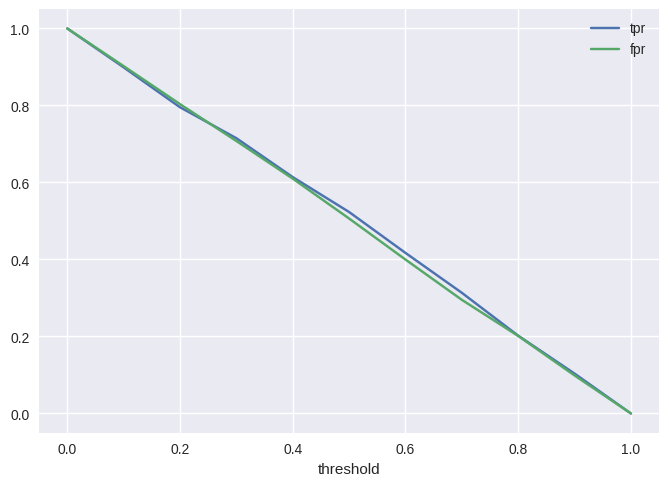

In [51]:
df_rand = tpr_fpr_dataframe(y_val=y_val,y_pred=y_rand)

df_rand[::10].plot(x='threshold',y=['tpr','fpr'])

### Ideal model

In [52]:
num_neg = (y_val == 0).sum()
num_pos = (y_val == 1).sum()
num_neg,num_pos

(1023, 386)

In [53]:
y_ideal = np.repeat([0,1],[num_neg,num_pos])
y_ideal

array([0, 0, 0, ..., 1, 1, 1])

In [54]:
y_ideal_pred = np.linspace(0,1,len(y_val))

In [56]:
((y_ideal >= 0.726) == y_ideal).mean()

1.0

<AxesSubplot:xlabel='threshold'>

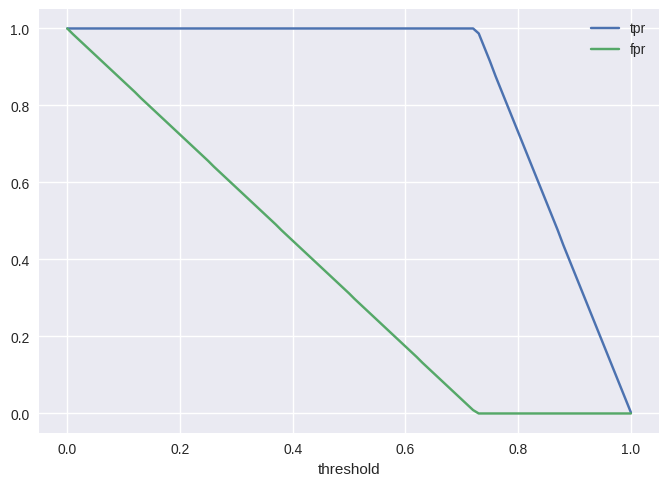

In [58]:
df_ideal = tpr_fpr_dataframe(y_ideal,y_ideal_pred)

df_ideal.plot(x='threshold',y=['tpr','fpr'])

<AxesSubplot:xlabel='threshold'>

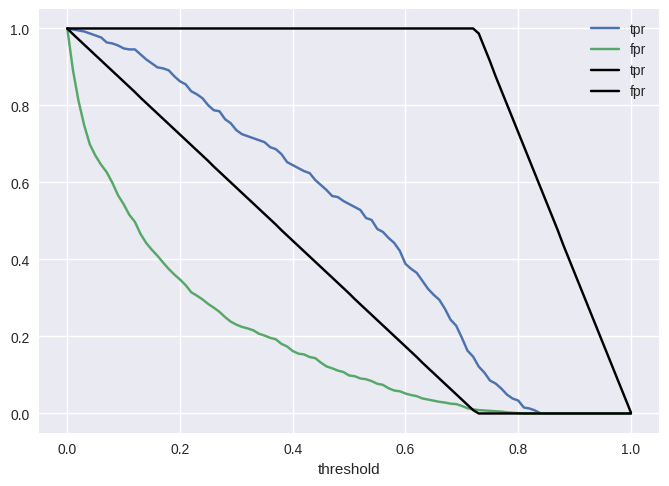

In [66]:
fig,ax=plt.subplots()
df_scores.plot(x='threshold',y=['tpr','fpr'],ax=ax)
#df_rand.plot(x='threshold',y=['tpr','fpr'],ax=ax)
df_ideal.plot(x='threshold',y=['tpr','fpr'],color='k',ax=ax)

Text(0, 0.5, 'TPR')

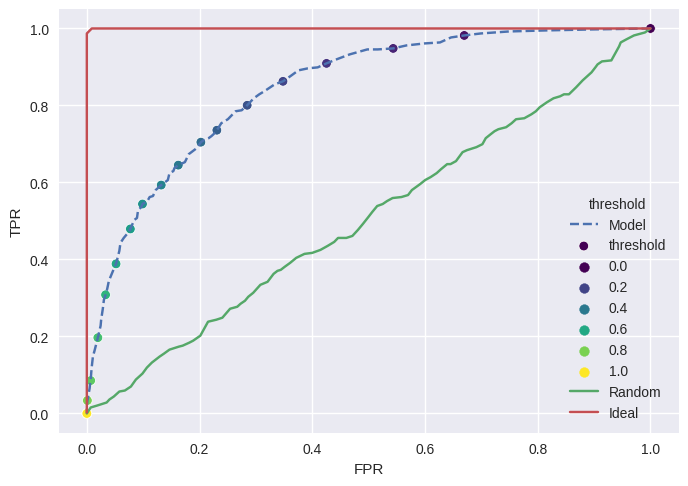

In [79]:
import seaborn as sns
fig,ax=plt.subplots()

df_scores.plot(x='fpr',y='tpr',label='Model',ls='--',ax=ax)
sns.scatterplot(x='fpr',y='tpr',hue='threshold',palette='viridis',data=df_scores[::5],label='threshold',ax=ax)
df_rand.plot(x='fpr',y='tpr',label='Random',ax=ax)
df_ideal.plot(x='fpr',y='tpr',label='Ideal',ax=ax)

ax.set_xlabel('FPR')
ax.set_ylabel('TPR')

We want to have our FPR/TPR curve as closest to the ideal model (0,1) and as far from the random model. 

Lets understand the figure above: 

- $FPR = 0 \land TPR = 0 $ (0,0): This happens at bigger threshold. We predict that they are negative. We dont predict any positive and the FPR = 0 because we only have True negatives.

- $FPR = 1 \land TPR = 1 $ (1,1): The trheshold is 0.0/ THis is where the model has 100% TPR because we predict everything as positive. We are able to identify all the positive values, but we made a lot of mistakes identifying the negative cases.

In [80]:
from sklearn.metrics import roc_curve

In [83]:
fpr,tpr,thrs = roc_curve(y_true=y_val,y_score=y_pred)

Text(0, 0.5, 'TPR')

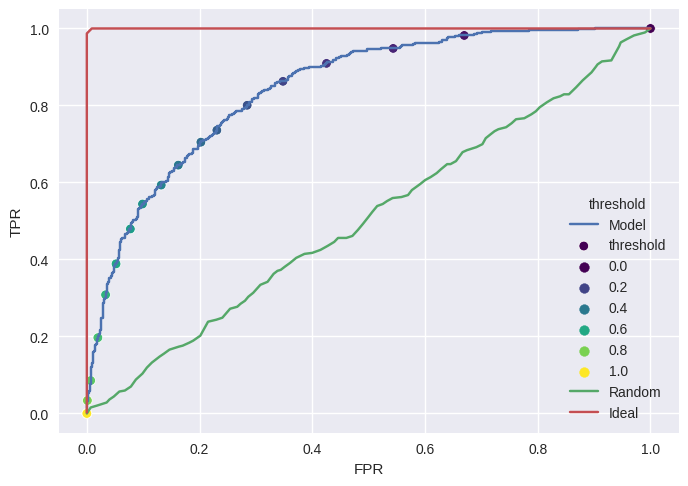

In [87]:
fig,ax=plt.subplots()

ax.plot(fpr,tpr,label='Model')
sns.scatterplot(x='fpr',y='tpr',hue='threshold',palette='viridis',data=df_scores[::5],label='threshold',ax=ax)
df_rand.plot(x='fpr',y='tpr',label='Random',ax=ax)
df_ideal.plot(x='fpr',y='tpr',label='Ideal',ax=ax)

ax.set_xlabel('FPR')
ax.set_ylabel('TPR')

## 4.6 ROC AUC

- Area under the ROC - useful metric
- Interpretation of AUC

AUC values:
- Ideal model $ AUC = 1 $
- random model $AUC \approx 0.5$

So our model should have an AUC between 0.5 and 1 and we target to maximize AUC

In [88]:
from sklearn.metrics import auc

In [89]:
auc(fpr,tpr)

0.843850505725819

In [90]:
auc(df_scores.fpr,df_scores.tpr)

0.8438808948586651

In [91]:
auc(df_ideal.fpr,df_ideal.tpr)

0.9999430203759136

In [92]:
auc(df_rand.fpr,df_rand.tpr)

0.5060233793728696

In [93]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_val,y_pred)

0.843850505725819

AUC can be interpreted as the probability that a randomly selected positive example has higher score than a randomly selected negative example.

$Proba(Pos_{score} > Neg_{score}) = AUC $

In [94]:
neg = y_pred[y_val == 0]
pos = y_pred[y_val == 1]

In [95]:
import random 

In [97]:
pos_idx = random.randint(0,len(pos) - 1)
neg_idx = random.randint(0,len(neg) - 1)
pos_idx,neg_idx

(212, 981)

In [98]:
pos[pos_idx] > neg[neg_idx]

True

In [101]:
n = 10000
sucess = 0

for i in range(n):
    pos_idx = random.randint(0,len(pos) - 1)
    neg_idx = random.randint(0,len(neg) - 1)
    
    if pos[pos_idx] > neg[neg_idx]:
        sucess += 1

print(f"The sucess ratio {sucess/n} is almost equal to AUC")

The sucess ratio 0.8424 is almost equal to AUC


In [106]:
n = 10000
np.random.seed(1)
pos_idx = np.random.randint(0,len(pos),size=n)
neg_idx = np.random.randint(0,len(neg),size=n)
(pos[pos_idx] > neg[neg_idx]).sum() / n

0.8412

## 4.7 Cross-validation

- Evaluating the same model on different subsets of data
- Getting the average prediction and the spread withing predictions
- Hyper-parameter tuning


We can split our dataset in the following way:

|full train [80%] | test [20%]|
|---|------
|D1 D2 D3 | test |

We use the full train dataset and split it in K folds; in this example K=3

|train|validate|AUC|
|-|-|-|
|D1 D2 | D3 |AUC1|
|D1 D3 | D2 |AUC2|
|D2 D3 | D1 |AUC3|


We can compute the mean AUC and the Standard deviation.





In [134]:
def train(df,y_train,C=1.0):
    dicts = df[categorical+numerical].to_dict(orient='records')
    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(dicts)

    model = LogisticRegression(C=C,max_iter=1000)
    model.fit(X_train,y_train)

    return dv,model 

In [135]:
dv,model = train(df_train,y_train)

In [136]:
def predict(df,dv,model):
    
    dicts = df[categorical+numerical].to_dict(orient='records')
    X = dv.transform(dicts)
    y_pred = model.predict_proba(X)[:,1]
    
    return y_pred 

In [137]:
y_pred = predict(df_val,dv,model)
y_pred

array([0.15611419, 0.00690853, 0.67572331, 0.10187985, 0.58758631,
       0.31291451, 0.25923392, 0.22185223, 0.0042437 , 0.07893422,
       0.0521258 , 0.01930876, 0.49969097, 0.74873084, 0.31170543,
       0.19263626, 0.65443704, 0.26359591, 0.27366301, 0.04917417,
       0.71008927, 0.04162581, 0.00465323, 0.49930442, 0.77651988,
       0.08666344, 0.7269335 , 0.04349264, 0.6645523 , 0.00865733,
       0.03895334, 0.01211871, 0.42983428, 0.58124773, 0.11923805,
       0.04479141, 0.54368454, 0.22520733, 0.77409192, 0.63563542,
       0.31021801, 0.26229317, 0.74583802, 0.00939694, 0.00343335,
       0.56662708, 0.38513043, 0.29831134, 0.08542337, 0.50561288,
       0.01070902, 0.00839357, 0.53989937, 0.62791521, 0.19279844,
       0.07796344, 0.00588776, 0.41918774, 0.02854869, 0.00653003,
       0.03014194, 0.68786214, 0.26613982, 0.05203161, 0.64785862,
       0.02840576, 0.75732711, 0.07131101, 0.17693419, 0.02579381,
       0.4127622 , 0.38553545, 0.50775891, 0.15962155, 0.72446

In [138]:
from sklearn.model_selection import KFold

In [139]:
kfold = KFold(n_splits=10,shuffle=True,random_state=1)

In [140]:
train_idx,val_idx = next(kfold.split(df_full_train))

len(df_full_train),len(train_idx),len(val_idx)

(5634, 5070, 564)

In [141]:
df_full_train.iloc[train_idx]

,customerid,gender,seniorcitizen,partner,dependents,tenure,phoneservice,multiplelines,internetservice,onlinesecurity,...,deviceprotection,techsupport,streamingtv,streamingmovies,contract,paperlessbilling,paymentmethod,monthlycharges,totalcharges,churn
1814,5442-pptjy,male,0,yes,yes,12,yes,no,no,no_internet_service,...,no_internet_service,no_internet_service,no_internet_service,no_internet_service,two_year,no,mailed_check,19.70,258.35,0
5946,6261-rcvns,female,0,no,no,42,yes,no,dsl,yes,...,yes,yes,no,yes,one_year,no,credit_card_(automatic),73.90,3160.55,1
3881,2176-osjuv,male,0,yes,no,71,yes,yes,dsl,yes,...,no,yes,no,no,two_year,no,bank_transfer_(automatic),65.15,4681.75,0
2389,6161-erdgd,male,0,yes,yes,71,yes,yes,dsl,yes,...,yes,yes,yes,yes,one_year,no,electronic_check,85.45,6300.85,0
611,4765-oxppd,female,0,yes,yes,9,yes,no,dsl,yes,...,yes,yes,no,no,month-to-month,no,mailed_check,65.00,663.05,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2763,2250-ivbwa,male,0,yes,yes,64,yes,no,fiber_optic,yes,...,no,no,no,no,month-to-month,no,electronic_check,81.05,5135.35,0
5192,3507-gasnp,male,0,no,yes,60,yes,no,no,no_internet_service,...,no_internet_service,no_internet_service,no_internet_service,no_internet_service,two_year,no,mailed_check,19.95,1189.90,0
3980,8868-wozgu,male,0,no,no,28,yes,yes,fiber_optic,no,...,yes,no,yes,yes,month-to-month,yes,electronic_check,105.70,2979.50,1
235,1251-krreg,male,0,no,no,2,yes,yes,dsl,no,...,no,no,no,no,month-to-month,yes,mailed_check,54.40,114.10,1


In [142]:
from tqdm.auto import tqdm

In [144]:
scores = []
for train_idx,val_idx in tqdm(kfold.split(df_full_train)):
    df_train = df_full_train.iloc[train_idx]
    df_val = df_full_train.iloc[val_idx]

    y_train = df_train.churn.values
    y_val = df_val.churn.values

    dv,model = train(df_train,y_train)
    y_pred = predict(df_val,dv,model)

    auc = roc_auc_score(y_val,y_pred)

    scores.append(auc)

10it [00:02,  4.50it/s]


In [145]:
scores

[0.8479398247539081,
 0.8414294554455446,
 0.8557214756739697,
 0.8344086906427454,
 0.8251085607940447,
 0.8342657342657342,
 0.8412569195701727,
 0.8186669829222013,
 0.8452052764191493,
 0.8618029646062317]

In [146]:
print('AUC %.3f +- %.3f' % (np.mean(scores),np.std(scores)))

AUC 0.841 +- 0.012


Now, we can also explore the effect of regularization *C*

In [159]:
n_splits = 5

C_scores = {}
for C in tqdm([0.001,0.01,0.1,0.5,1,5,10]):
    scores = []
    kfold = KFold(n_splits=n_splits,shuffle=True,random_state=1)
    for train_idx,val_idx in kfold.split(df_full_train):
        df_train = df_full_train.iloc[train_idx]
        df_val = df_full_train.iloc[val_idx]

        y_train = df_train.churn.values
        y_val = df_val.churn.values

        dv,model = train(df_train,y_train,C=C)
        y_pred = predict(df_val,dv,model)

        auc = roc_auc_score(y_val,y_pred)

        scores.append(auc)

    mean = np.mean(scores).round(3)
    std = np.std(scores).round(3)
    print('C=%s :AUC %.3f +- %.3f' % (C,np.mean(scores),np.std(scores)))

    C_scores.update({C:{'mean':mean,'std':std}})

 14%|█▍        | 1/7 [00:01<00:06,  1.14s/it]

C=0.001 :AUC 0.825 +- 0.009


 29%|██▊       | 2/7 [00:02<00:05,  1.13s/it]

C=0.01 :AUC 0.840 +- 0.009


 43%|████▎     | 3/7 [00:03<00:04,  1.15s/it]

C=0.1 :AUC 0.841 +- 0.008


 57%|█████▋    | 4/7 [00:04<00:03,  1.23s/it]

C=0.5 :AUC 0.841 +- 0.006


 71%|███████▏  | 5/7 [00:06<00:02,  1.26s/it]

C=1 :AUC 0.840 +- 0.009


 86%|████████▌ | 6/7 [00:07<00:01,  1.33s/it]

C=5 :AUC 0.841 +- 0.008


100%|██████████| 7/7 [00:08<00:00,  1.25s/it]

C=10 :AUC 0.841 +- 0.008


In [160]:
C_scores

{0.001: {'mean': 0.825, 'std': 0.009},
 0.01: {'mean': 0.84, 'std': 0.009},
 0.1: {'mean': 0.841, 'std': 0.008},
 0.5: {'mean': 0.841, 'std': 0.006},
 1: {'mean': 0.84, 'std': 0.009},
 5: {'mean': 0.841, 'std': 0.008},
 10: {'mean': 0.841, 'std': 0.008}}

Lets train the model with the full train dataset

In [162]:
dv,model = train(df_full_train,df_full_train.churn,C=1.0)
y_pred = predict(df_test,dv,model)

auc = roc_auc_score(y_test,y_pred)
auc

0.8572386167896259